# Experiments with Moving Barrier Contraint
Here, we will consider the moving barrier constraint and assess the stability. From experiment, I have found the following:

- The "step size" of the barrier matters for stability. Too large step size would lead to divergence.
- The case $\delta=1$ (transport and generation/destruction are equally weighted) seems to perform poorly for the constraint.
- For $\delta=0.01, \delta=10$, the result is more natural.

In [16]:
# import required libraries

import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact

## Constraint 1: Two walls
In this section, we consider the following maze with two walls: ![maze](maze.png "maze"). As an initial condition, we place a Gaussian bump at top left and the terminal condition has the bump at bottom right.

In [72]:
from PIL import Image

def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

# Moving barrier generator. This is specific to maze.png.
def fill_region(frames, fps, speed, original, Hstep):
    rows, cols = 30, 30
    step_size = speed*14/fps

    # Define the region to fill
    start_col, end_col = 1, 14

    # Create a list to store each frame
    filled_frames = [original]

    for i in range(1,frames):
        frame = filled_frames[-1].copy()
        # Determine the slice to fill based on speed
        end_fill = max(1, int(end_col - i*step_size))
        frame[18:20, end_fill:14] += Hstep
        # if above 1, clip to 1
        frame[frame > 1.0] = 1.0
        
        # Append the current state of the array to the list
        filled_frames.append(frame.copy())
    
    return filled_frames

maze = (1-image_to_numpy('maze.png').squeeze()/255)

def plot_frames(t, frames):
    plt.figure(figsize=(2,2))
    plt.imshow(frames[t])
    plt.tight_layout()
    plt.show()

# Example of filling a region with a moving barrier
T = 30
frames = fill_region(T, 30, 1.0, maze, Hstep=0.05)
interact(lambda t: plot_frames(t, frames), t=widgets.IntSlider(min=0, max=T-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=29), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

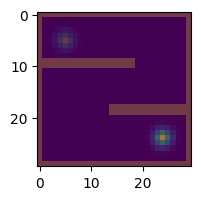

In [73]:
# We will use the following parameters for the rest of the notebook
T = 30
N1 = maze.shape[0]
N2 = maze.shape[1]
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(2, 2))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()

# Result plotters
def plot_maze_2(t, x, H, xx, yy, rho_0, rho_1, ismask=False):
    f, axes = plt.subplots(1, 3, figsize=[10, 5])

    ax1, ax2, ax3 = axes
    if t<=0:
        ax1.imshow(H[0])
        ax1.imshow(rho_0, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[0], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][0], x.V.D[1][0], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    elif t>=T:
        ax1.imshow(H[T-1])
        ax1.imshow(rho_1, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[T-1], vmin=-5, vmax=5)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][T-1], x.V.D[1][T-1], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    else:
        masked1 = np.ma.masked_where(np.abs(x.V.D[0][t]) < 1e-3 , x.V.D[0][t])
        if ismask:
            ax1.imshow(masked1)
        else:
            ax1.imshow(H[t])
            ax1.imshow(x.V.D[0][t], alpha=0.5)
        masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3 , x.V.Z[t])
        cmap = plt.cm.viridis
        cmap.set_bad(color='white')  # Set color for masked values (zero values)
        ims2 = ax2.imshow(masked, vmin=-5, vmax=5)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')

    plt.show()

def convergence_plots(lists, x, H, F, dx):
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|([0,1]\times \Omega)$")
    plt.xlabel(r"$\ell$")
    plt.title("Disgresion of the constraint")
    plt.semilogy(lists[1], "k")

    plt.subplot(2, 2, 2)
    plt.ylabel(r"$|F_{\delta}^{(\ell)}-F_{\delta}^{(niter)}|$")
    plt.xlabel(r"$\ell$")
    plt.title("Convergence of the functional")
    minF = np.min(lists[0][-10:])
    plt.semilogy(np.minimum(1, np.abs(lists[0] - np.mean(lists[0][-10:]))), "k")

    plt.subplot(2, 2, 3)
    plt.title("$\sum_{t}|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each iteration")
    plt.plot(lists[2], "k")

    plt.subplot(2, 2, 4)
    plt.title("$|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each t for the final solution")
    plt.plot(np.abs(np.sum(x.V.D[0]*H, axis=(1,2))*dx-F), "k")

    plt.show()


### Example 1: Step size = 1, $\delta=1$

In [74]:
frames = fill_region(T, 30, 1.0, maze, Hstep=1.0)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 1.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=3000)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [64]:
plot_elements1 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_2(t, *plot_elements1), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=30), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

The result turned out to be very poor, and as the following plots suggest, the solution has diverged.

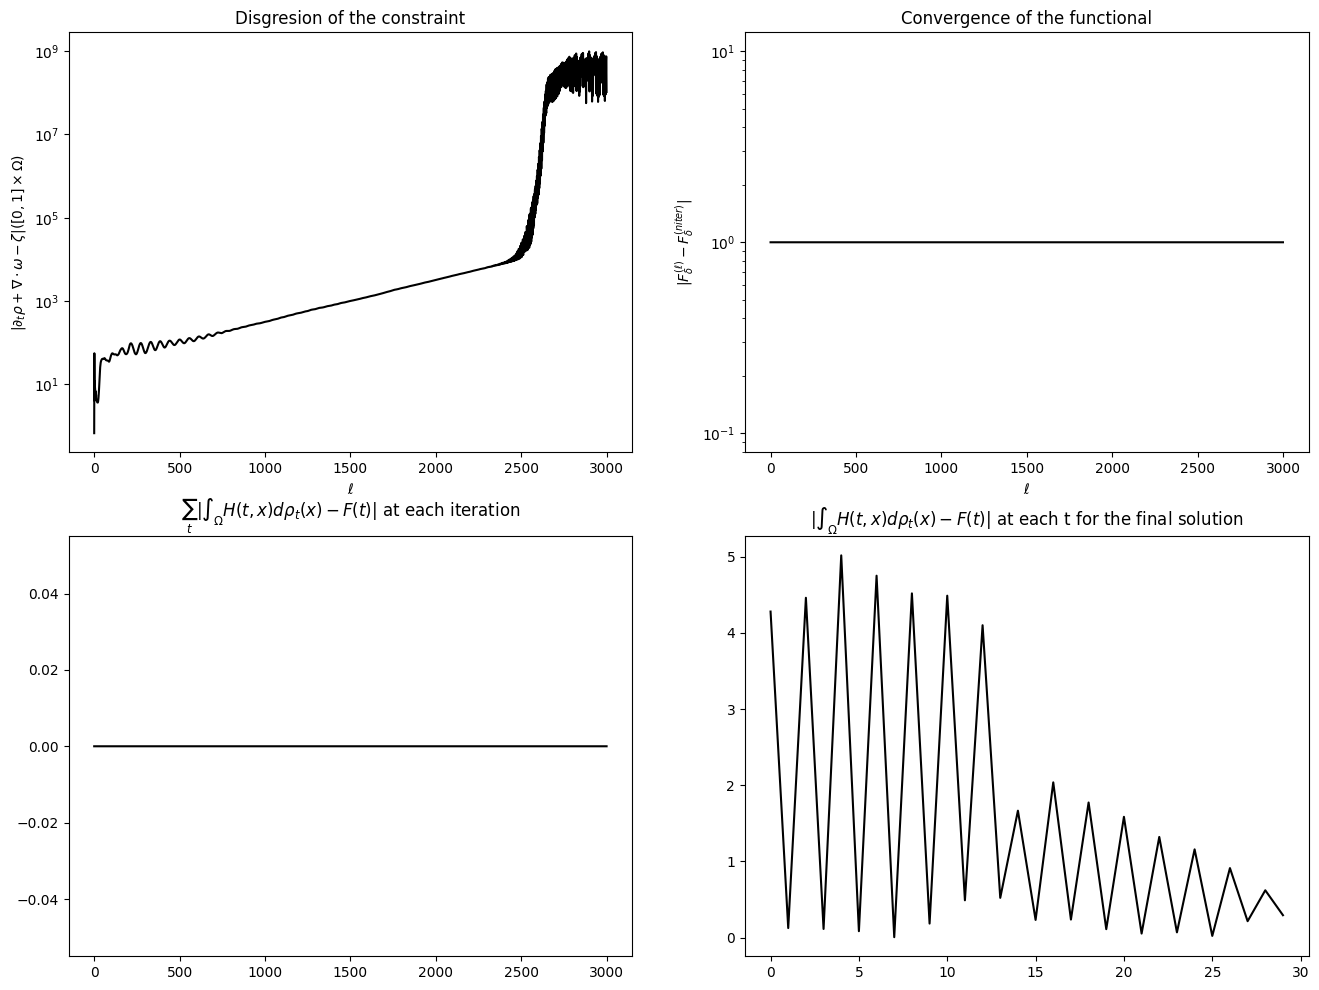

In [65]:
convergence_plots(lists, x, H, F, math.prod(dx))

### Example 2: Step size = 1, $\delta= 10$
As we will see later, the step size is the best way to control the convergence. Here, we will see if $\delta$ can contribute to it.

In [32]:
frames = fill_region(T, 30, 1.0, maze, Hstep=1.0)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 1.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=10.0, niter=10000)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [33]:
plot_elements2 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_2(t, *plot_elements2), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=30), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

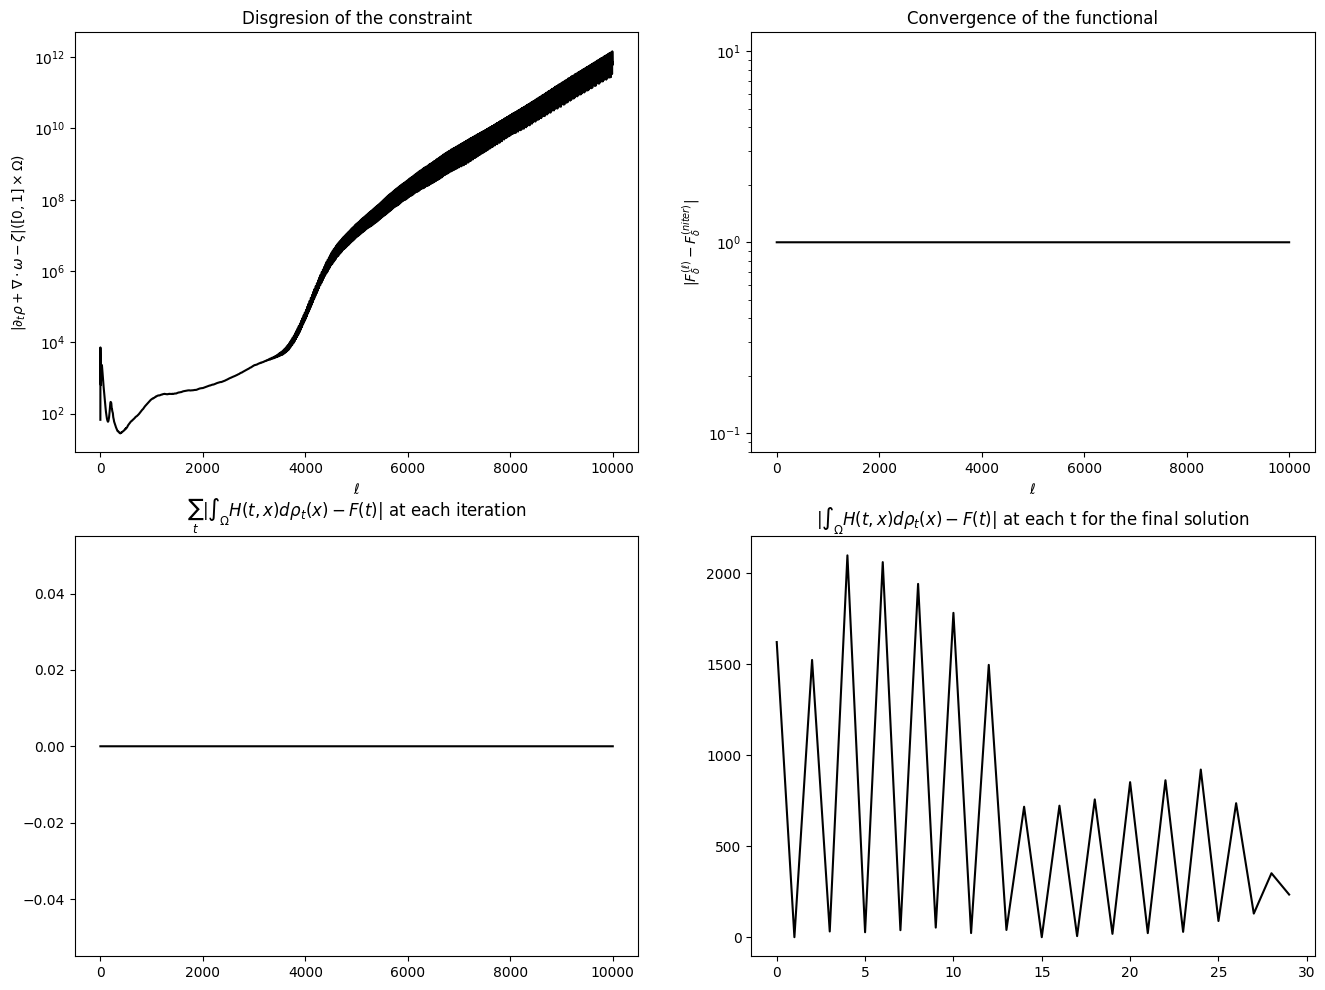

In [34]:
convergence_plots(lists, x, H, F, math.prod(dx))

Although the divergence is less intense, we still have a bad solution.

### Example 3: Step size = 0.01, $\delta=1$
We will now decrease the step size to see if we obtain a good solution.

In [37]:
frames = fill_region(T, 30, 1.0, maze, Hstep=0.01)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 1.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=10000)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [38]:
plot_elements3 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_2(t, *plot_elements3), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=30), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

As the following graph shows, we have obtained a solutiion that is not divergent, but as you can see in the above plot, the mass basically "teleports" through the wall, making the constraint basically useless.

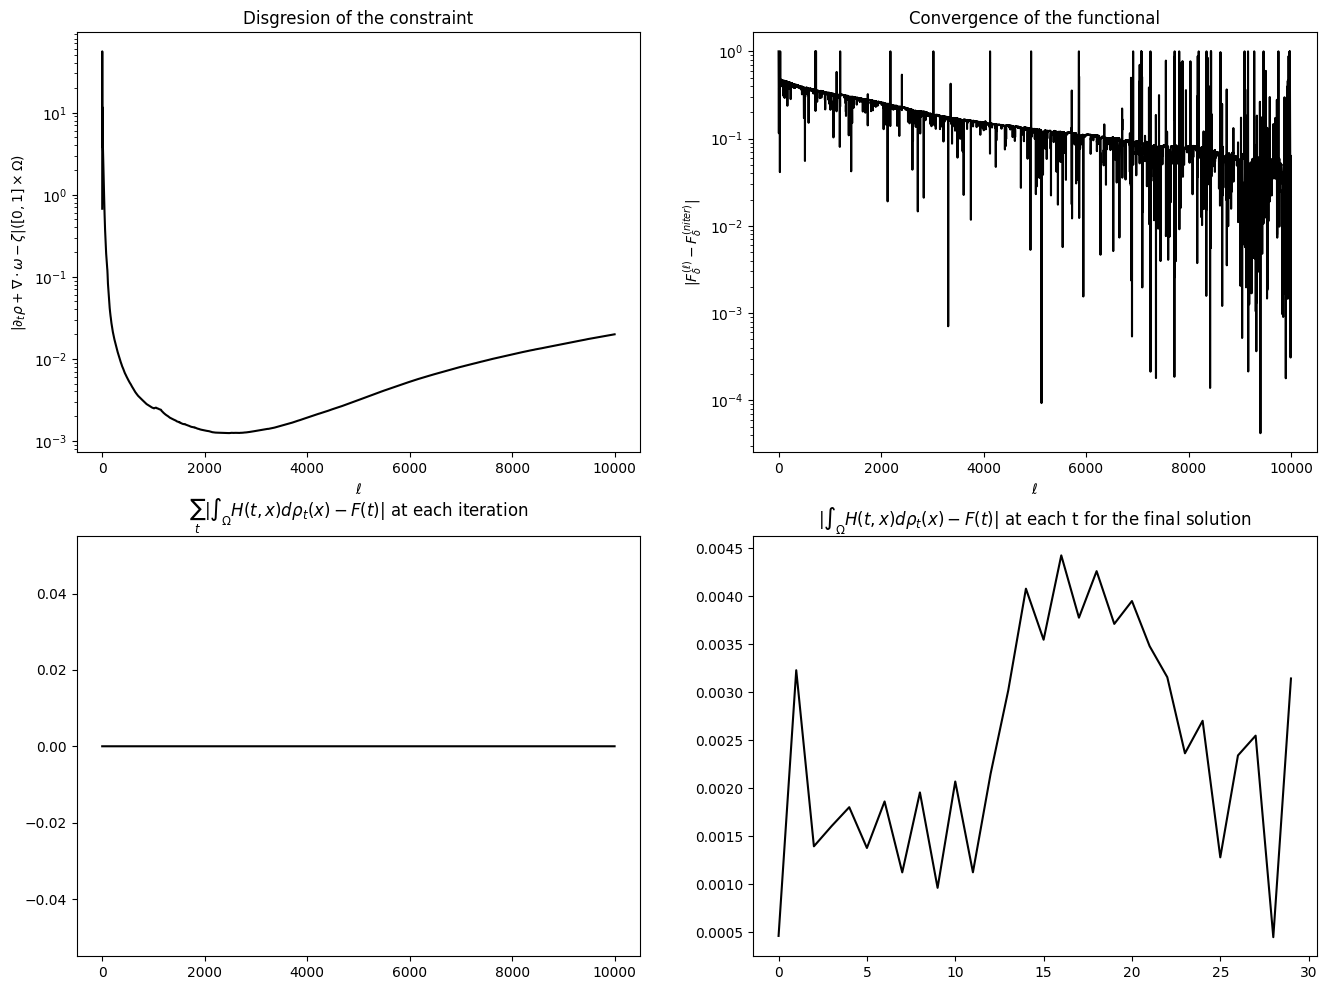

In [39]:
convergence_plots(lists, x, H, F, math.prod(dx))

### Example 4: Step size = 0.01, $\delta=10$
We will now see that if we reduce the mass transportation, we will see a sensible result.

In [45]:
frames = fill_region(T, 30, 1.0, maze, Hstep=0.01)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 1.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=10.0, niter=10000)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [46]:
plot_elements4 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_2(t, *plot_elements4), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=30), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

We can see that the mass respects the barrier, resulting in a very natural solution. 

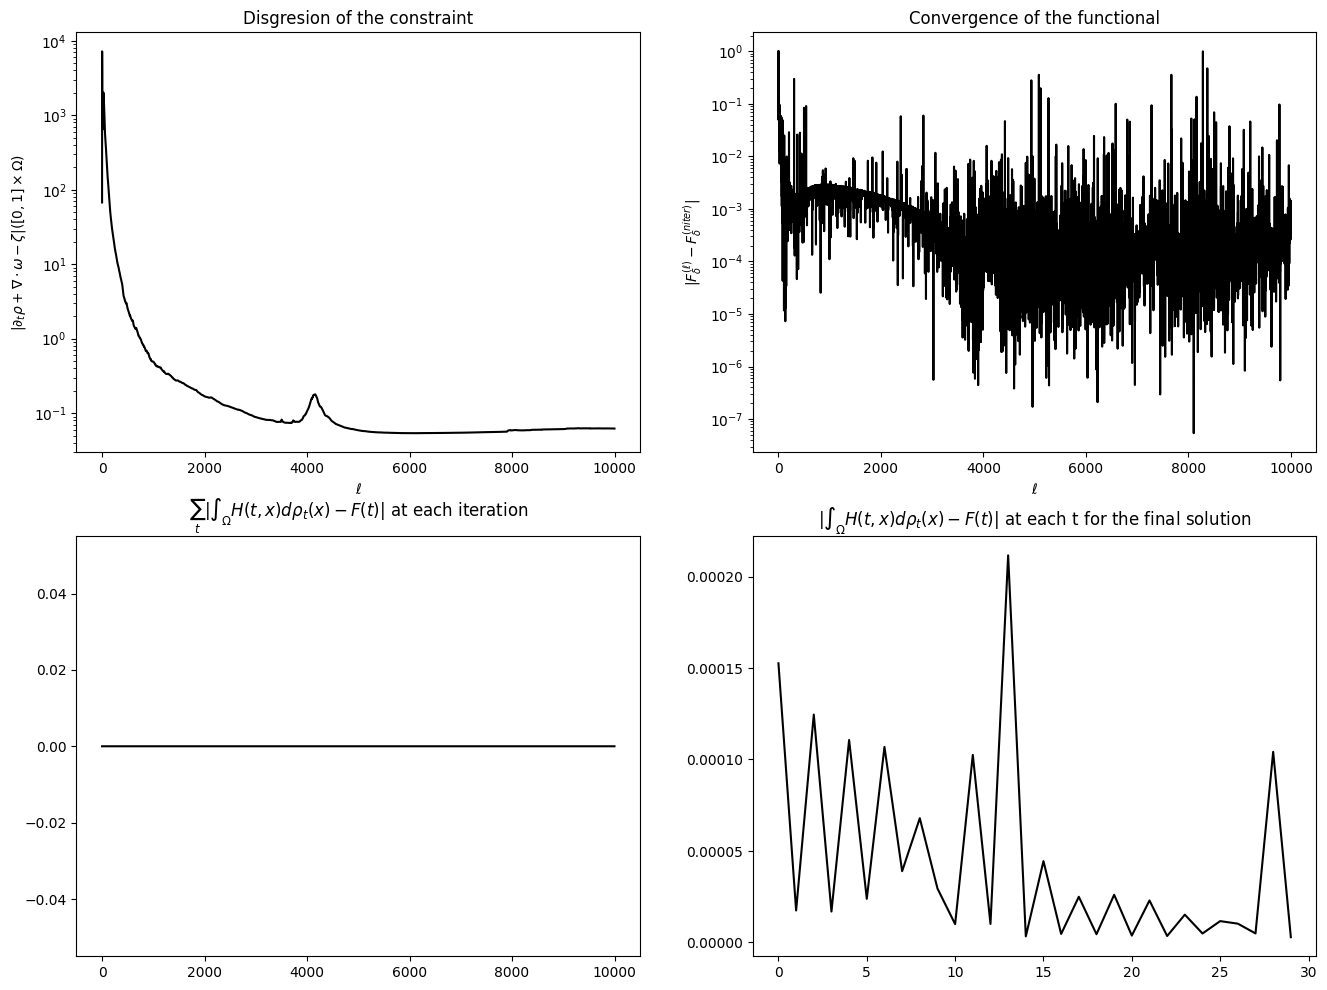

In [44]:
convergence_plots(lists, x, H, F, math.prod(dx))

### Example 5: Example 4 with less number of iterations
The graphs in Example 4 has a bump at #iterations=4000. We will see what happens here.

In [50]:
frames = fill_region(T, 30, 1.0, maze, Hstep=0.01)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 1.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=10.0, niter=4000)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [51]:
plot_elements5 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_2(t, *plot_elements5), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=30), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

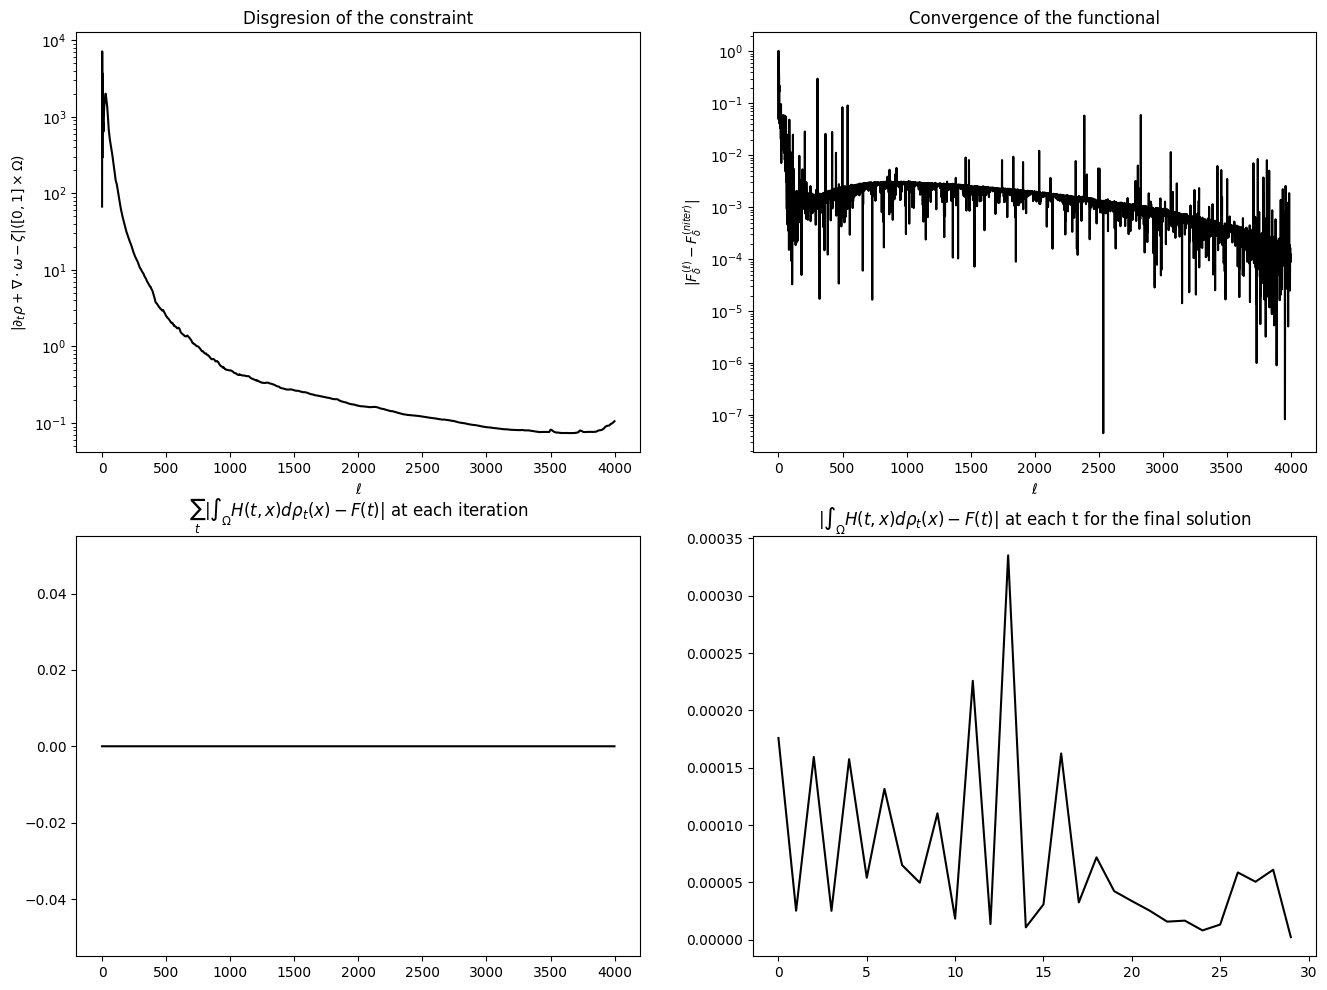

In [52]:
convergence_plots(lists, x, H, F, math.prod(dx))